# Quantum simulation

  *Approximate QPU time to run this experiment is 7 seconds.*

  (This notebook is mostly taken from a now-deprecated [tutorial notebook](https://github.com/qiskit-community/qiskit-algorithms/blob/main/docs/tutorials/13_trotterQRTE.ipynb) for Qiskit Algorithms.)
</Admonition>



## 1. Introduction

As a real time evolution technique, Trotterization consists in the successive application of a quantum gate or gates, chosen to approximate the time evolution of a system for a time slice. Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian governing the system. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j P_j$, with $P_j$ representing a tensor product of Pauli terms acting on $n$ qubits. In particular, these Pauli terms might commute with one another, or they might not. Given a state at time $t=0$, how do we obtain the system's state at a later time $|\psi(t)\rangle$ using a quantum computer? The exponential of an operator can be most easily understood through its Taylor series:

$$
e^{-i H t} = 1-iHt-\frac{1}{2}H^2t^2+...
$$

Some very basic exponentials, like $e^{iZ}$ can be implemented easily on quantum computers using a compact set of quantum gates. Most Hamiltonians of interest will not have just a single term, but will instead have many terms. Note what happens if $H = H_1+H_2$:

$$
e^{-i H t} = 1-i(H_1+H_2)t-\frac{1}{2}(H_1+H_2)^2t^2+...
$$

When $H_1$ and $H_2$ commute, we have the familiar case (which is also true for numbers, and variables $a$ and $b$ below):

$$
e^{-i (a+b) t} = e^{-i a t}e^{-i b t}
$$

But when operators do not commute, terms cannot be rearranged in the Taylor series to simplify in this way. Thus, expressing complicated Hamiltonians in quantum gates is a challenge.

One solution is to consider very small time $t$, such that the first-order term in the Taylor expansion dominates. Under that assumption:

$$
e^{-i (H_1+H_2) t} \approx 1-i(H_1+H_2)t \approx (1-i H_1 t)(1-i H_2 t) \approx e^{-i H_1 t}e^{-i H_2 t}
$$

Of course, we might need to evolve our state for a longer time. That is accomplished by using many such small steps in time. This process is called Trotterization:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j P_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

Here $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation (a non-negligible concern on near-term quantum devices).

Today, we will study the time evolution of the [Ising model](https://en.wikipedia.org/wiki/Ising_model) on linear lattices of $N=2$ and $N=6$ sites. These lattices consist of an array of spins $\sigma_i$ that interact only with their nearest neighbors. These spins can have two orientations: $\uparrow$ and $\downarrow$, which correspond to a magnetization of $+1$ and $-1$ respectively.

$$
H = - J \sum_{i=0}^{N-2} Z_i Z_{i+1} - h \sum_{i=0}^{N-1} X_i  \text{,}
$$

where $J$ describes the interaction energy, and $h$ the magnitude of an external field (in the x-direction above, but we will modify this). Let us write this expression using Pauli matrices, and considering that the external field has an angle $\alpha$ with respect to the transversal direction,

$$
H = -J \sum_{i=0}^{N-2} Z_i Z_{i+1} -h \sum_{i=0}^{N-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{.}
$$

This Hamiltonian is useful in that it allows us to easily study the effects of an external field. In the computational basis, the system will be encoded as follows:

|       Quantum state      |             Spin representation            |
| :----------------------: | :----------------------------------------: |
| $\lvert 0 0 0 0 \rangle$ |     $\uparrow\uparrow\uparrow\uparrow$     |
| $\lvert 1 0 0 0 \rangle$ |    $\downarrow\uparrow\uparrow\uparrow$    |
|         $\ldots$         |                  $\ldots$                  |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

We will start investigating the time evolution of such a quantum system. More specifically, we will visualize the time-evolution of certain properties of the system like magnetization.



### 1.1 Requirements

Before starting this tutorial, be sure you have the following installed:

*   Qiskit SDK v1.2 or later ( `pip install qiskit` )
*   Qiskit Runtime v0.30 or later ( `pip install qiskit-ibm-runtime` )
*   Numpy v1.24.1 or later \< 2 ( `pip install numpy` )



### 1.2 Import the libraries

Note that some libraries that might be useful (MatrixExponential, QDrift) are included even though they are not used in this current notebook. You can try them out if you have time!



In [ ]:
#Installing the required libraries

# Install Qiskit and upgrade to the latest version
%pip install qiskit --upgrade

# Install the Qiskit Aer library for simulation
%pip install qiskit qiskit-aer --upgrade

# Install Qiskit visualization tools
%pip install qiskit[visualization] --upgrade

# Install Qiskit IBM Rumtime
%pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=122237a525d0c4caa8bcfdc78dd66646006abfe462c8f0f08a0a16a944727eef
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Check the version of Qiskit
import qiskit

qiskit.__version__

'2.1.1'

In [ ]:
# Import the qiskit library
import numpy as np
import matplotlib.pylab as plt
import warnings

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.synthesis import (
    SuzukiTrotter,
    LieTrotter,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

warnings.filterwarnings("ignore")

## 2. Mapping your problem

### 2.1 Defining the transverse-field Ising Hamiltonian

We here consider the 1-D transverse-field Ising model.

First, we will create a function that takes in the system parameters $N$, $J$, $h$ and $\alpha$, and returns our Hamiltonian as a `SparsePauliOp`. A [SparsePauliOp](/docs/api/qiskit/qiskit.quantum_info.SparsePauliOp) is a sparse representation of an operator in terms of weighted [Pauli](/docs/api/qiskit/qiskit.quantum_info.Pauli) terms.



In [ ]:
def get_hamiltonian(nqubits, J, h, alpha):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, nqubits)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, nqubits)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list(
        [*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=nqubits
    )
    return hamiltonian.simplify()

#### Define the Hamiltonian

The system that we now consider has a size of $N=6$, $J=0.2$, $h=1.2$ and $\alpha=\frac{\pi}{8.0}$ as an example.



In [ ]:
n_qubits = 6

hamiltonian = get_hamiltonian(nqubits=n_qubits, J=0.2, h=1.2, alpha=np.pi / 8.0)
hamiltonian

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.2       +0.j, -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j,
 -0.45922012+0.j, -0.45922012+0.j, -0.45922012+0.j, -1.10865544+0.j,
 -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j, -1.10865544+0.j,
 -1.10865544+0.j])

### 2.2 Set the parameters of the time-evolution simulation

Here we will consider three different Trotterization techniques:

*   Lie–Trotter (first order)
*   second-order Suzuki–Trotter
*   fourth-order Suzuki–Trotter

The latter two will be used in the exercise, and in the appendix.



In [ ]:
num_timesteps = 60
evolution_time = 30.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()
product_formula_st2 = SuzukiTrotter(order=2)
product_formula_st4 = SuzukiTrotter(order=4)

### 2.3 Prepare the quantum circuit 1 (Initial state)

Create an initial state. Here we will start with a spin configuration of $\uparrow\uparrow\downarrow\downarrow\uparrow\uparrow$
.



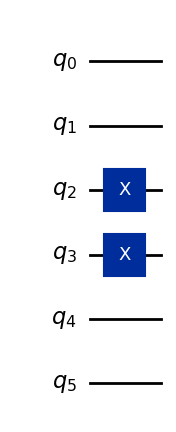

In [ ]:
initial_circuit = QuantumCircuit(n_qubits)
initial_circuit.prepare_state("001100")
# Change reps and see the difference when you decompose the circuit
initial_circuit.decompose(reps=1).draw("mpl")

### 2.4 Prepare the quantum circuit 2 (Single circuit for time evolution)

We here construct a circuit for a single time step using Lie–Trotter.

The Lie product formula (first-order) is implemented in the [LieTrotter](/docs/api/qiskit/qiskit.synthesis.LieTrotter) class. A first-order formula consists of the approximation stated in the introduction, where the matrix exponential of a sum is approximated by a product of matrix exponentials:

$$
e^{H_1+H_2} \approx e^{H_1} e^{H_2}
$$

As previously mentioned, very deep circuits lead to the accumulation of errors, and cause problems for modern quantum computers. Because two-qubit gates have higher error rates than single-qubit gates, a quantity of particular interest is the two-qubit circuit depth. What really matters is the two-qubit circuit depth after transpilation (since that is the circuit the quantum computer actually executes). But let us get in the habit of counting the operations for this circuit, even now using the simulator.




Trotter step with Lie-Trotter
-----------------------------
Depth: 17
Gate count: 27
Nonlocal gate count: 10
Gate breakdown: U: 12, CX: 10, P: 5



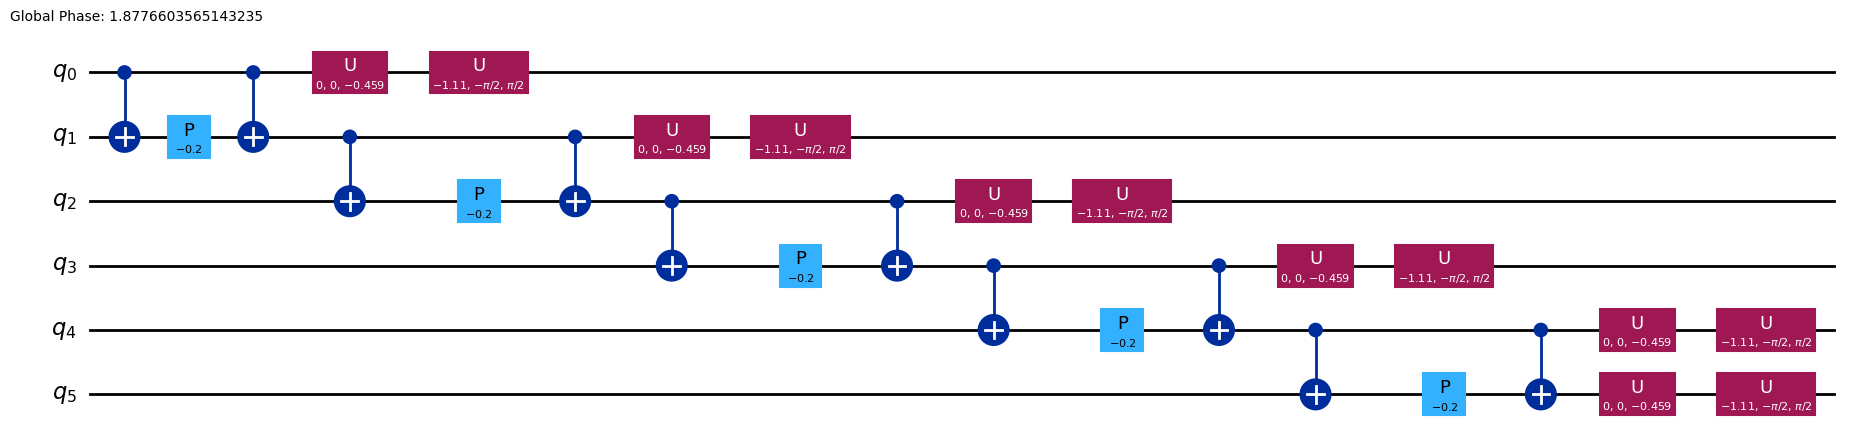

In [ ]:
single_step_evolution_gates_lt = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt = QuantumCircuit(n_qubits)
single_step_evolution_lt.append(
    single_step_evolution_gates_lt, single_step_evolution_lt.qubits
)

print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

### 2.5 Set the operators to measure

Let us define a *magnetization operator* $\sum_i \langle Z_i \rangle / N$, and a *mean spin correlation operator* $\sum_i \langle Z_i Z_{i+1} \rangle/ (N - 1)$.



In [ ]:
magnetization = (
    SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n_qubits)], num_qubits=n_qubits
    )
    / n_qubits
)
correlation = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, n_qubits - 1)], num_qubits=n_qubits
) / (n_qubits - 1)
print("magnetization : ", magnetization)
print("correlation : ", correlation)

magnetization :  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])
correlation :  SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


### 2.6 Perform time-evolution simulation

We will monitor the energy (expectation value of the Hamiltonian), magnetization (expectation value of the magnetization operator), and mean spin correlation (expectation value of the mean spin correlation operator). Qiskit's `StatevectorEstimator` (EstimatorV2) primitive estimates expectation values of observables, $\langle\psi\vert\hat{O}\vert\psi\rangle$.



In [ ]:
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
energy_list = []
mag_list = []
corr_list = []
# Estimate expectation values for t=0.0
job = estimator.run(
    [(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision
)
# Get estimated expectation values
evs = job.result()[0].data.evs
energy_list.append(evs[0])
mag_list.append(evs[1])
corr_list.append(evs[2])
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_gates_lt, evolved_state.qubits)
    # Estimate expectation values at delta-t
    job = estimator.run(
        [(evolved_state, [hamiltonian, magnetization, correlation])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job.result()[0].data.evs
    energy_list.append(evs[0])
    mag_list.append(evs[1])
    corr_list.append(evs[2])
# Transform the list of expectation values (at each time step) to arrays
energy_array = np.array(energy_list)
mag_array = np.array(mag_list)
corr_array = np.array(corr_list)

### 2.7 Plot the time evolution of the observables

We plot the expectation values we measured against time.



Text(0.5, 0.98, 'Observable evolution')

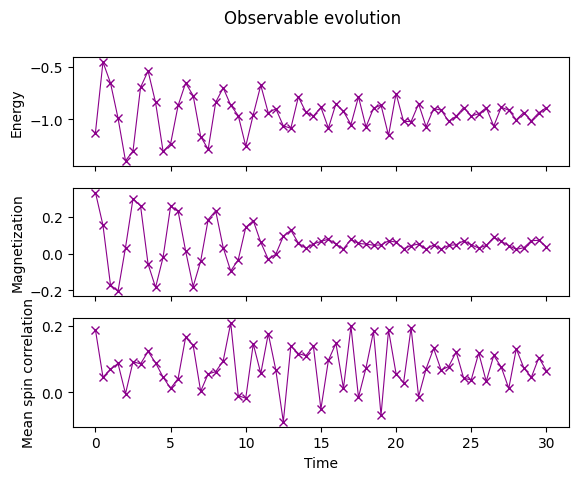

In [ ]:
fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times,
    energy_array,
    label="First order",
    marker="x",
    c="darkmagenta",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times, mag_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, corr_array, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

## 3. Exercise 1. Perform simulation using second-order Suzuki–Trotter

Now let's try performing simulation with second-order Suzuki–Trotter following the example of Lie–Trotter shown above.

The second-order Suzuki-Trotter can be used in Qiskit by means of the [SuzukiTrotter class](/docs/api/qiskit/qiskit.synthesis.SuzukiTrotter). Using this formula, a second order decomposition is:

$$
e^{H_1+H_2} \approx e^{H_1/2}e^{H_2}e^{H_1/2}
$$



### 3.1 Construct a circuit for a single time step

Use product\_formula\_st2 (SuzukiTrotter(order=2)) and construct a circuit for a single time step using second-order Suzuki–Trotter. Also, count the number of gates and depth of the circuit and compare with Lie–Trotter.




Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: 34
Gate count: 53
Nonlocal gate count: 20
Gate breakdown: U: 23, CX: 20, P: 10



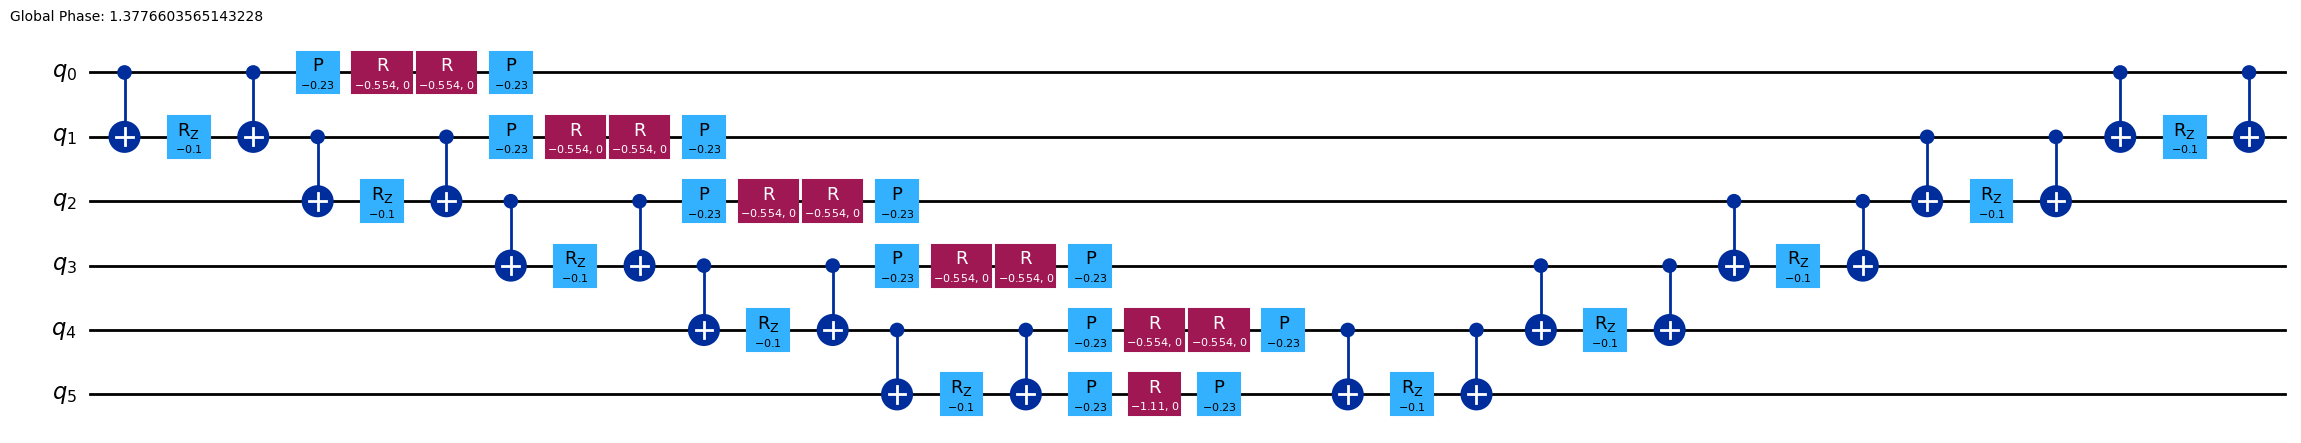

In [ ]:
# Modify the line below (Use PauliEvolutionGate)
single_step_evolution_gates_st2 = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_st2
)
single_step_evolution_st2 = QuantumCircuit(n_qubits)
single_step_evolution_st2.append(
    single_step_evolution_gates_st2, single_step_evolution_st2.qubits
)
# Let us print some stats
print(
    f"""
Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: {single_step_evolution_st2.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_st2.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_st2.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_st2.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_st2.decompose(reps=2).draw("mpl", fold=-1)

### 3.2 Perform time-evolution simulation

Perform time evolution using second-order Suzuki–Trotter.



In [ ]:
# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
energy_list_st2 = []
mag_list_st2 = []
corr_list_st2 = []
# Estimate expectation values for t=0.0
job = estimator.run(
    [(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision
)
# Get estimated expectation values
evs = job.result()[0].data.evs
energy_list_st2.append(evs[0])
mag_list_st2.append(evs[1])
corr_list_st2.append(evs[2])
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_gates_st2, evolved_state.qubits)
    # Estimate expectation values at delta-t
    job = estimator.run(
        [(evolved_state, [hamiltonian, magnetization, correlation])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job.result()[0].data.evs
    energy_list_st2.append(evs[0])
    mag_list_st2.append(evs[1])
    corr_list_st2.append(evs[2])
# Transform the list of expectation values (at each time step) to arrays
energy_array_st2 = np.array(energy_list_st2)
mag_array_st2 = np.array(mag_list_st2)
corr_array_st2 = np.array(corr_list_st2)

### 3.3 Plot the second-order Suzuki–Trotter results



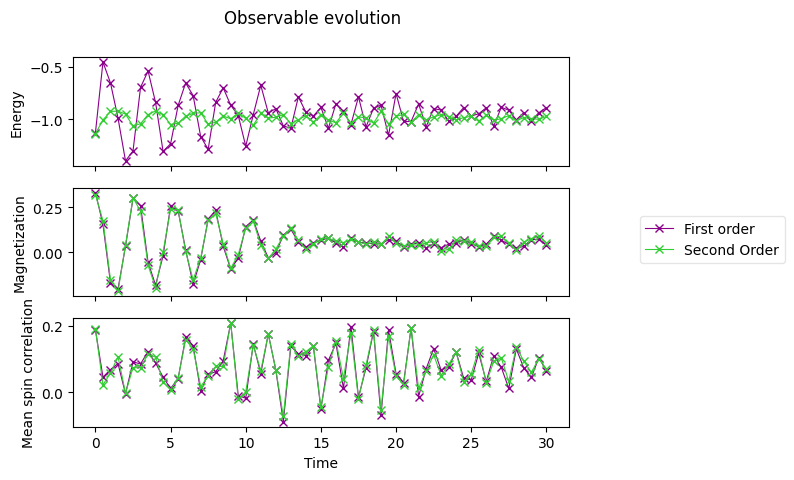

In [ ]:
axes[0].plot(
    times,
    energy_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)
axes[1].plot(
    times,
    mag_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)
axes[2].plot(
    times,
    corr_array_st2,
    label="Second Order",
    marker="x",
    c="limegreen",
    ls="-",
    lw=0.8,
)

# Replace the legend
# legend.remove()
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

### 3.4 Compare with exact results

The data below is the precomputed exact results from the classical computer.



In [ ]:
exact_times = np.array(
    [
        0.0,
        0.3,
        0.6,
        0.8999999999999999,
        1.2,
        1.5,
        1.7999999999999998,
        2.1,
        2.4,
        2.6999999999999997,
        3.0,
        3.3,
        3.5999999999999996,
        3.9,
        4.2,
        4.5,
        4.8,
        5.1,
        5.3999999999999995,
        5.7,
        6.0,
        6.3,
        6.6,
        6.8999999999999995,
        7.199999999999999,
        7.5,
        7.8,
        8.1,
        8.4,
        8.7,
        9.0,
        9.299999999999999,
        9.6,
        9.9,
        10.2,
        10.5,
        10.799999999999999,
        11.1,
        11.4,
        11.7,
        12.0,
        12.299999999999999,
        12.6,
        12.9,
        13.2,
        13.5,
        13.799999999999999,
        14.1,
        14.399999999999999,
        14.7,
        15.0,
        15.299999999999999,
        15.6,
        15.899999999999999,
        16.2,
        16.5,
        16.8,
        17.099999999999998,
        17.4,
        17.7,
        18.0,
        18.3,
        18.599999999999998,
        18.9,
        19.2,
        19.5,
        19.8,
        20.099999999999998,
        20.4,
        20.7,
        21.0,
        21.3,
        21.599999999999998,
        21.9,
        22.2,
        22.5,
        22.8,
        23.099999999999998,
        23.4,
        23.7,
        24.0,
        24.3,
        24.599999999999998,
        24.9,
        25.2,
        25.5,
        25.8,
        26.099999999999998,
        26.4,
        26.7,
        27.0,
        27.3,
        27.599999999999998,
        27.9,
        28.2,
        28.5,
        28.799999999999997,
        29.099999999999998,
        29.4,
        29.7,
        30.0,
    ]
)
exact_energy = np.array(
    [
        -1.1184402376762155,
        -1.1184402376762157,
        -1.1184402376762157,
        -1.1184402376762148,
        -1.1184402376762153,
        -1.1184402376762155,
        -1.1184402376762148,
        -1.118440237676216,
        -1.118440237676216,
        -1.1184402376762166,
        -1.1184402376762148,
        -1.118440237676216,
        -1.1184402376762153,
        -1.1184402376762148,
        -1.118440237676217,
        -1.118440237676215,
        -1.1184402376762161,
        -1.1184402376762157,
        -1.118440237676217,
        -1.1184402376762161,
        -1.1184402376762137,
        -1.1184402376762161,
        -1.1184402376762161,
        -1.118440237676218,
        -1.1184402376762155,
        -1.1184402376762166,
        -1.1184402376762155,
        -1.1184402376762137,
        -1.1184402376762186,
        -1.1184402376762215,
        -1.1184402376762148,
        -1.118440237676216,
        -1.1184402376762166,
        -1.1184402376762148,
        -1.1184402376762121,
        -1.1184402376762166,
        -1.1184402376762181,
        -1.1184402376762137,
        -1.1184402376762148,
        -1.1184402376762193,
        -1.1184402376762108,
        -1.1184402376762144,
        -1.118440237676217,
        -1.1184402376762197,
        -1.1184402376762153,
        -1.1184402376762161,
        -1.1184402376762184,
        -1.1184402376762126,
        -1.118440237676214,
        -1.118440237676214,
        -1.1184402376762161,
        -1.118440237676212,
        -1.1184402376762164,
        -1.118440237676217,
        -1.1184402376762121,
        -1.1184402376762157,
        -1.1184402376762212,
        -1.1184402376762217,
        -1.1184402376762206,
        -1.118440237676222,
        -1.1184402376762166,
        -1.118440237676212,
        -1.1184402376762137,
        -1.11844023767622,
        -1.1184402376762206,
        -1.118440237676219,
        -1.1184402376762153,
        -1.1184402376762164,
        -1.118440237676209,
        -1.1184402376762144,
        -1.1184402376762161,
        -1.118440237676216,
        -1.1184402376762173,
        -1.118440237676214,
        -1.1184402376762093,
        -1.1184402376762184,
        -1.1184402376762126,
        -1.118440237676213,
        -1.1184402376762195,
        -1.1184402376762095,
        -1.1184402376762075,
        -1.1184402376762197,
        -1.1184402376762141,
        -1.1184402376762146,
        -1.1184402376762184,
        -1.118440237676218,
        -1.1184402376762224,
        -1.118440237676219,
        -1.118440237676218,
        -1.1184402376762206,
        -1.1184402376762168,
        -1.118440237676221,
        -1.118440237676218,
        -1.1184402376762148,
        -1.1184402376762106,
        -1.1184402376762173,
        -1.118440237676216,
        -1.118440237676216,
        -1.1184402376762113,
        -1.1184402376762275,
        -1.1184402376762195,
    ]
)
exact_magnetization = np.array(
    [
        0.3333333333333333,
        0.26316769633415005,
        0.0912947227110664,
        -0.09317712543141576,
        -0.20391854332115245,
        -0.19318196655046493,
        -0.06411527074401464,
        0.12558269854206197,
        0.28252754464640606,
        0.3264196194042506,
        0.2361586169847769,
        0.060894367906122224,
        -0.10842387093076275,
        -0.18636359582538073,
        -0.1338364343947887,
        0.020284606520827753,
        0.19151142743926025,
        0.2905341647678381,
        0.2723014646745304,
        0.15147481733047252,
        -0.008179102877790292,
        -0.1242999208732406,
        -0.1372529247781061,
        -0.04083616185958952,
        0.11066094926716476,
        0.23140661570567636,
        0.2587109403786205,
        0.1868237670027325,
        0.061201779383143744,
        -0.051391248969654205,
        -0.09843899603365061,
        -0.061297056158849166,
        0.04199010081939773,
        0.15861461430963147,
        0.22336830674799552,
        0.20179555623336537,
        0.11407111438609417,
        0.01609419104778282,
        -0.04239611796730001,
        -0.04249123521065924,
        0.008850291714888112,
        0.08780898151558082,
        0.1561486776507056,
        0.17627348772811832,
        0.13870676179652253,
        0.07205869195282538,
        0.018300003064909465,
        0.0001095640839572417,
        0.015157929316037586,
        0.05077755280969454,
        0.09245534457650838,
        0.12206907551110702,
        0.12284950557969157,
        0.09570215398601932,
        0.06294378255078983,
        0.045503313813986014,
        0.043389819499542556,
        0.046725117769796744,
        0.054956411358382404,
        0.0713814528253614,
        0.08743689703248492,
        0.08951216359166674,
        0.07878386475305985,
        0.06955669116405788,
        0.06639892435963689,
        0.05890378761746903,
        0.04541796525844558,
        0.0414221088331947,
        0.05499634106912299,
        0.07409418836014572,
        0.08371859070160165,
        0.08211623987959302,
        0.07615055161378328,
        0.06702584458783024,
        0.051891407742740085,
        0.038049378383635625,
        0.03825614149768043,
        0.054183218463525695,
        0.0753534475741016,
        0.08853147112587295,
        0.08767917178542013,
        0.07709383184439536,
        0.06308595032042386,
        0.0498812359204284,
        0.04299040064096167,
        0.04769159891460652,
        0.06483569572288776,
        0.08698035745435016,
        0.10047391641776235,
        0.09747255683203637,
        0.08098863187287358,
        0.05959496723987331,
        0.04383882265040485,
        0.04232138798062125,
        0.05720514169944535,
        0.08201306299870219,
        0.10274898262000469,
        0.10707552455080133,
        0.09210856128265357,
        0.06379922105742579,
        0.03624325103307953,
    ]
)
exact_correlation = np.array(
    [
        0.2,
        0.1247704225763532,
        0.01943938494098705,
        0.03854917181332821,
        0.11196616231067426,
        0.0906546700356683,
        0.01629373561896267,
        0.011352652889791095,
        0.0636185676540077,
        0.09543834437789013,
        0.10058518161011307,
        0.11829217731417431,
        0.1397812224038133,
        0.12316460402216707,
        0.08541383059335775,
        0.06144846844403662,
        0.020246372880505827,
        -0.02693683090021662,
        0.003919250903281282,
        0.1117419430168554,
        0.19676155181256794,
        0.18594408880783336,
        0.1002673802566004,
        0.03821525827438024,
        0.04485205090247377,
        0.05348102743040269,
        0.03160026140008638,
        0.033437649060464834,
        0.10486939975320728,
        0.20249469538955758,
        0.19735507621013149,
        0.0553097261765083,
        -0.04889114490131667,
        0.011685690974970964,
        0.11705971535823065,
        0.11681165998194759,
        0.06637091239560744,
        0.10936684225958895,
        0.20225454101061405,
        0.16284420833341812,
        -0.0025823294931362067,
        -0.0763416631752919,
        0.02985268630418397,
        0.15234468006771007,
        0.14606385406970995,
        0.0935341856492092,
        0.12325421854361143,
        0.17130422930386324,
        0.10383730044042278,
        -0.031333159406547614,
        -0.05241572078596815,
        0.07722509925347705,
        0.17642188574256007,
        0.12765340239966838,
        0.06309968945093776,
        0.11574687130499339,
        0.16978282647206913,
        0.0736143632571229,
        -0.05356602733119409,
        -0.0009649396796768892,
        0.15921620111869142,
        0.17760366431811037,
        0.04736297330213485,
        0.012122870263181897,
        0.13268065586830521,
        0.1728473023503636,
        0.03999259331072221,
        -0.036997053070222885,
        0.06951528580242439,
        0.1769169993516561,
        0.12290448295710298,
        0.012897784654866427,
        0.02859435620982225,
        0.12895847695150875,
        0.13629536955485938,
        0.05394621059822597,
        0.02298040588184324,
        0.07036499900317271,
        0.11706448623132719,
        0.10435285842074606,
        0.055721236329964965,
        0.04676334743672697,
        0.08417924910022263,
        0.10611161955304965,
        0.089304171047322,
        0.06098589533081194,
        0.06314519797488709,
        0.09431492621892917,
        0.09667836915967139,
        0.0651298357290882,
        0.05176966009147416,
        0.06727229484222669,
        0.08871788283607947,
        0.09907054249093444,
        0.09785167773502176,
        0.09277216140054353,
        0.07520999642062785,
        0.05894392248382922,
        0.07236135251622376,
        0.08608284185200156,
        0.07282922961856123,
    ]
)

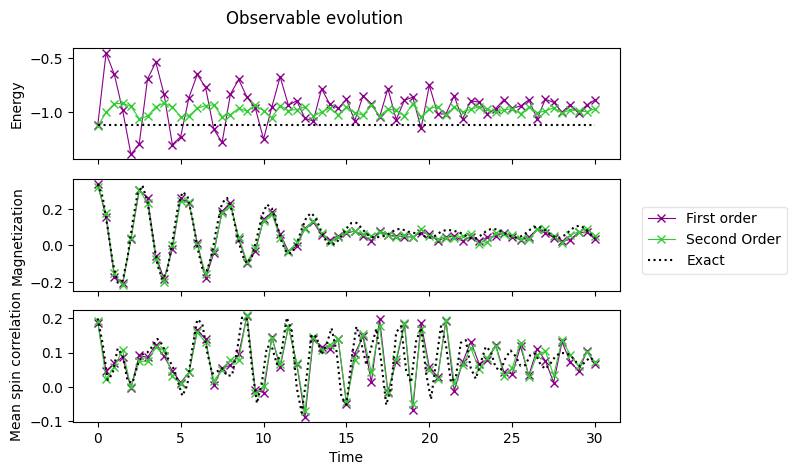

In [ ]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")
# Replace the legend
legend.remove()
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig

## 4. Executing on the quantum hardware

We next run the time-evolution simulation on the quantum hardware. We will work on a smaller problem, lattice size N=2. We vary the $\alpha$ parameter and see the difference in dynamics of the wavefunction.



### 4.1  Step 1. Map classical inputs to a quantum problem

Pick the initial setting of the simulation:



In [ ]:
n_qubits_2 = 2
dt_2 = 1.6
product_formula = LieTrotter(reps=1)

Then set the initial circuit:

The initial spin configuration will be "down-up"



In [ ]:
# We prepare an initial state ↓↑ (10).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_circuit_2 = QuantumCircuit(n_qubits_2)
initial_circuit_2.prepare_state("10")
# Change reps and see the difference when you decompose the circuit
initial_circuit_2.decompose(reps=1).draw("mpl")

<Image src="/learning/images/courses/utility-scale-quantum-computing/quantum-simulation/extracted-outputs/f33796b1-7511-46b0-93ff-ee6e6188c412-0.avif" alt="Output of the previous code cell" />

Now compute the reference value using an ideal statevector simulator.



In [ ]:
bar_width = 0.1
# initial_state = Statevector.from_label("10")
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    evolved_state_2 = QuantumCircuit(initial_circuit_2.num_qubits)
    evolved_state_2.append(initial_circuit_2, evolved_state_2.qubits)
    hamiltonian_2 = get_hamiltonian(nqubits=2, J=0.2, h=1.0, alpha=alpha)
    single_step_evolution_gates_2 = PauliEvolutionGate(
        hamiltonian_2, dt_2, synthesis=product_formula
    )
    evolved_state_2.append(single_step_evolution_gates_2, evolved_state_2.qubits)
    evolved_state_2 = Statevector(evolved_state_2)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state_2.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

<Image src="/learning/images/courses/utility-scale-quantum-computing/quantum-simulation/extracted-outputs/8469258b-bb82-4e46-b3d6-43aee59d9474-1.avif" alt="Output of the previous code cell" />

We have prepared a system initially with a sequence of spins $\downarrow\uparrow$, which corresponds to $\vert\psi(0)\rangle = \vert10\rangle$. After letting it evolve for $t=1.6$ under a transversal field ($\alpha=0^\circ$), we are almost guaranteed to measure $\uparrow\downarrow$, that is, have a spin swap. (Note that the labels are interpreted from right to left). If the field is longitudinal ($\alpha=\pm90^\circ$), we will have no evolution, therefore we will measure the system as it was initially prepared, $\downarrow\uparrow$. With intermediate angles, at $\alpha=\pm45^\circ$, we will be able to measure all combinations will different probabilities, being a spin swap the most likely with a probability of 67%.



#### Construct circuit for HW experiment



In [ ]:
circuit_list = []
for i, alpha in enumerate(alphas):
    evolved_state_2 = QuantumCircuit(initial_circuit_2.num_qubits)
    evolved_state_2.append(initial_circuit_2, evolved_state_2.qubits)
    hamiltonian_2 = get_hamiltonian(nqubits=2, J=0.2, h=1.0, alpha=alpha)
    single_step_evolution_gates_2 = PauliEvolutionGate(
        hamiltonian_2, dt_2, synthesis=product_formula
    )
    evolved_state_2.append(single_step_evolution_gates_2, evolved_state_2.qubits)
    evolved_state_2.measure_all()
    circuit_list.append(evolved_state_2)

### 4.2 Step 2. Optimize for target hardware

We specify a backend.



In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_strasbourg'

Then we transpile the circuit for the selected backend.



In [ ]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
circuit_isa = pm.run(circuit_list)

Check out the circuit.



In [ ]:
circuit_isa[1].draw("mpl", idle_wires=False)

<Image src="/learning/images/courses/utility-scale-quantum-computing/quantum-simulation/extracted-outputs/64d9166e-296a-4a6d-a6d1-0b6fdd49399b-0.avif" alt="Output of the previous code cell" />

### 4.3 Step 3. Execute with Qiskit Runtime primitives

Qiskit's `Sampler` (V2) primitive provides the counts of measured bitstrings.



In [ ]:
sampler = SamplerV2(mode=backend)
job = sampler.run(circuit_isa)
job_id = job.job_id()
print("job id:", job_id)

job id: d13pswfmya70008ek070


Save the results



In [ ]:
results = job.result()

### 4.4 Step 4. Post-process results

Construct the histogram of the bitstrings, which corresponds to analyzing the wavefunction, and compare them with the ideal values shown above.



In [ ]:
list_temp = ["00", "01", "10", "11"]

for i, alpha in enumerate(alphas):
    # Dictionary of probabilities
    amplitudes_dict = results[i].data.meas.get_counts()
    values = []
    for str_temp in list_temp:
        values.append(
            amplitudes_dict[str_temp] / 4096.0
        )  # divided by default number of shots
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probabilities")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

<Image src="/learning/images/courses/utility-scale-quantum-computing/quantum-simulation/extracted-outputs/1f4e5fbd-1994-4f4d-8d35-ddf1a37664b7-1.avif" alt="Output of the previous code cell" />

We here show an example for constructing a circuit using higher-order (fourth-order) Suzuki–Trotter.
Now let's try constructing a circuit simulation with fourth-order Suzuki–Trotter following the examples shown above.

The fourth-order Suzuki–Trotter can be used in Qiskit by means of the [SuzukiTrotter class](/docs/api/qiskit/qiskit.synthesis.SuzukiTrotter). The fourth-order can be evaluated using the following recursion relation. Note that the order of Suzuki–Trotter is denoted as "2k" in the following equations.

$$
\hat{U}_{ST(2k)}\left(t\right) = \left[ \hat{U}_{ST(2k-2)}\left(p_k t\right) \right]^2 \hat{U}_{ST(2k-2)}\left( (1- 4 p_k) t\right)\left[ \hat{U}_{ST(2k-2)}\left(p_k t\right) \right]^2
$$

$$
p_k = 1 / \left(4-4^{\frac{1}{2k-1}}\right)
$$



#### Construct a circuit for a single time step

Use product\_formula\_st4 (SuzukiTrotter(order=4)) and construct a circuit for a single time step using fourth-order Suzuki–Trotter. Also, count the number of gates and depth of the circuit and compare with Lie–Trotter and second-order Suzuki–Trotter.



In [ ]:
# Modify the line below (Use PauliEvolutionGate)
single_step_evolution_gates_st4 = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_st4
)
single_step_evolution_st4 = QuantumCircuit(n_qubits)
single_step_evolution_st4.append(
    single_step_evolution_gates_st4, single_step_evolution_st4.qubits
)
# Let us print some stats
print(
    f"""
Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: {single_step_evolution_st4.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_st4.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_st4.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_st4.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_st4.decompose(reps=2).draw("mpl", fold=-1)


Trotter step with second-order Suzuki-Trotter
-----------------------------
Depth: 170
Gate count: 265
Nonlocal gate count: 100
Gate breakdown: U3: 115, CX: 100, U1: 50



<Image src="/learning/images/courses/utility-scale-quantum-computing/quantum-simulation/extracted-outputs/e20ea669-82d3-42a7-89f6-bab7d41689f1-1.avif" alt="Output of the previous code cell" />

In [ ]:
# Check Qiskit version
import qiskit

qiskit.__version__

'2.0.2'

© IBM Corp., 2017-2025